# INF0429 - Robótica
## Lab02 - Localizaçao com LiDAR

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore
from IPython import display

/home/kuntur/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Mapa do ambiente
landmarks = np.array([[ 3.00085905, -0.62390064],
                      [ 3.89524457,  0.36092648],
                      [ 3.9005231 ,  2.80069002],
                      [ 3.06272609,  2.80621234],
                      [ 3.04464186,  3.41088797],
                      [-1.14314437,  3.41088816],
                      [-1.15656156,  2.07743863],
                      [-2.49979193,  2.06182513],
                      [-2.50508263, -0.62015044]], dtype=np.float32)

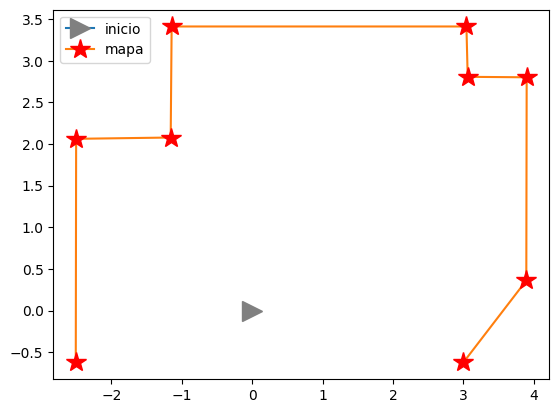

In [3]:
_, ax = plt.subplots(1, 1)
plt.plot(0, 0, marker='>', markersize=15, mec='gray', mfc='gray', label='inicio')
plt.plot(landmarks[:, 0], landmarks[:, 1], marker='*', markersize=15, mec='r', mfc='r', label='mapa')
plt.legend()
plt.show()

### Funções importantes

In [4]:
def Polar2Cartesian(r, alpha):
    return np.transpose(np.array([np.cos(alpha)*r, np.sin(alpha)*r]))

def getDistance(P, Ps, Pe): # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P-Ps)

    return np.divide(np.abs(np.linalg.norm(np.cross(Pe-Ps, Ps-P))),np.linalg.norm(Pe-Ps))

def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i,:], P[0,:], P[-1,:])
        if (d > dmax):
            index = i
            dmax = d

    return dmax, index

def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)

    if (d > threshold):
        P1 = SplitAndMerge(P[:ind+1, :], threshold) # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold) # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))

    return points

### Configurando parâmetros dos sensores LiDAR e odom

In [5]:
typestore = get_typestore(Stores.ROS2_FOXY)

# create reader instance and open for reading
with Reader('./albot_tours0/') as reader:    
    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/scan': # LiDAR @ 10 Hz
            # typestore = get_typestore(Stores.ROS2_FOXY)
            lidar = typestore.deserialize_cdr(rawdata, connection.msgtype)

            # Lidar parametros do feixe
            lidar_th_min = lidar.angle_min # -90 deg
            lidar_th_max = lidar.angle_max # +90 deg
            lidar_th_step = lidar.angle_increment # +1 deg
            lidar_angles = np.arange(lidar_th_min, lidar_th_max + lidar_th_step, lidar_th_step) # radianos
            
            break
            
        if connection.topic == '/imu': # IMU @ 100 Hz
            # typestore = get_typestore(Stores.ROS2_FOXY)
            imu = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Covariancia do acelerometro
            Q_acc = imu.linear_acceleration_covariance.reshape((3, 3)).astype(np.float32)
            
            # Covariancia do giroscopio
            Q_gyr = imu.angular_velocity_covariance.reshape((3, 3)).astype(np.float32)
            
            # Vetor de ruido dos sensores inerciais
            w_imu = np.sqrt(np.array([[Q_acc[0, 0]],
                                      [Q_acc[1, 1]],
                                      [Q_gyr[2, 2]]]))
            
        if connection.topic == '/odom': # odometry @ 100 Hz
            odom = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Vetor de ruido dos encoders
            w_odom = np.sqrt(np.diag(np.array(odom.twist.covariance).reshape(6, 6)))[:, np.newaxis] # linear, angular
            

### Laço de processamento on-line

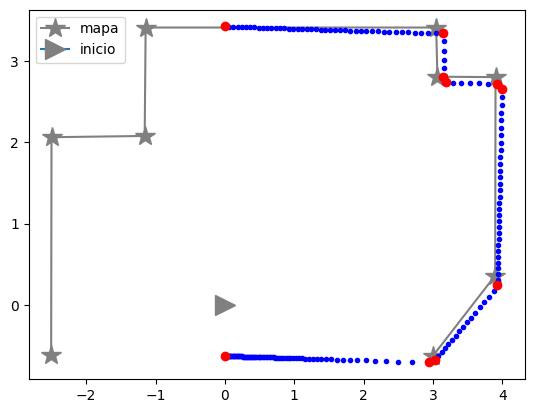

In [6]:
# Reference: https://answers.ros.org/question/358686/how-to-read-a-bag-file-in-ros2/

# Plots
fig, _ = plt.subplots()
plt.plot(landmarks[:, 0], landmarks[:, 1], marker='*', markersize=15, color='gray', mec='gray', mfc='gray', label='mapa')
plt.plot(0, 0, marker='>', markersize=15, mec='gray', mfc='gray', label='inicio')
plt.legend()

threshold_SM = 0.025 # Split & Merge threshold

typestore = get_typestore(Stores.ROS2_FOXY)

# create reader instance and open for reading
with Reader('./albot_tours0/') as reader:
    # iterate over messages
    for connection, timestamp, rawdata in reader.messages():
        if connection.topic == '/scan':
            print('LIDAR')
            lidar = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Lidar distancias
            lidar_ranges = lidar.ranges
            
            # Coordenadas 2D dos feixes
            lidar_x = lidar_ranges * np.cos(lidar_angles)
            lidar_y = lidar_ranges * np.sin(lidar_angles)
            
            # Split & Nerge
            P = Polar2Cartesian(lidar_ranges, lidar_angles)
            lidar_corners = SplitAndMerge(P, threshold_SM)
            
            # Plots
            plt.plot(lidar_x, lidar_y, 'b.')
            plt.plot(lidar_corners[:, 0], lidar_corners[:, 1], 'or')
            display.display(fig)
            display.clear_output(wait=True)
            break

        if connection.topic == '/imu':
            print('IMU')
            imu = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            # Accelerometer data
            acc = np.array([imu.linear_acceleration.x, imu.linear_acceleration.y, imu.linear_acceleration.z], dtype=np.float32)
            
            # Gyroscope data
            gyr = np.array([imu.angular_velocity.x, imu.angular_velocity.y, imu.angular_velocity.z], dtype=np.float32)
            
        if connection.topic == '/odom': # wheel odometry @ 100 Hz
            print('ODOM')
            odom = typestore.deserialize_cdr(rawdata, connection.msgtype)
            
            linear = np.array([odom.twist.twist.linear.x, odom.twist.twist.linear.y, odom.twist.twist.linear.z], dtype=np.float32)
            angular = np.array([odom.twist.twist.angular.x, odom.twist.twist.angular.y, odom.twist.twist.angular.z], dtype=np.float32)